# Рекомендательная система "Покажи мне свой товар и я скажу кто ты"

Цели и задачи проекта: разработка рекомендательной системы для крупной компании он-лайн ритейла. Рекомендательная система должна основываться на наиболее точной рекомендации верного товара в высокой ценовой категории.

**Импорт библиотек и данных. Первичный осмотр.**

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import json
import re
import seaborn as sns
from datetime import datetime
from pandas import Series
import matplotlib.pyplot as plt

import pandas_profiling

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import auc, roc_auc_score, roc_curve
import warnings 
warnings.simplefilter('ignore')

Пропишем функцию для отображения ROC-кривой:

In [16]:
def roc_auc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [17]:
train = pd.read_csv('train_food.csv')
test = pd.read_csv('test_food.csv')
submission = pd.read_csv('sample_submission_food.csv')

Описание:

test.csv - набор данных, для которого вы должны сделать предсказания. У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание.
* overall - рейтинг, который поставил пользователь
* verified - был ли отзыв верифицирован
* reviewTime - когда был отзыв написан
* reviewerName - имя пользователя
* reviewText - текст отзыва
* summary - сжатый отзыв
* vote - количество голосований за отзыв
* style - метаданные
* image - изображение продукта
* userid - id пользователя
* itemid - id товара
* id - id для предсказания

In [18]:
# прочитаем json с метаданными и положим результат в датасет "meta"
# вероятно здесь имеются данные, которые могут улучшить нашу модель
with open('meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)


In [19]:
# первичный осмотр
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))
print('Размерность мета датасета: ', meta.shape)
display(meta.head(5))

Размерность тренировочного датасета:  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


Размерность тестового датасета:  (285965, 11)


,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


Размерность мета датасета:  (287209, 17)


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


Первичный анализ трех датасетов, говорит, что это достаточно большие датасеты. Признаки из тренировочно и мета датасеты не полностью сопадают с тестовым. 
В тренировочном датасете на три столбца больше:

* overall - оценка по пятибальной шкале
* reviewText - текст отзыва
* summary - краткое содержание отзыва
* rating - целевая переменная

отсутствует Id - id для предсказания

При этом объединение датасетов возможно, можно это сделать по признаку 'asin', который является уникальным идентификатором товара на Амазон.

In [20]:
# удалим идентичные записи
train.drop_duplicates(inplace = True)

In [21]:
# образуем новый датасет после объединения метаданных и тренировочного датасета
train_new = pd.merge(train, meta, on='asin')

**EDA**

In [22]:
# начнем работу с новым датасетом
train_new.head(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,NaN,117314,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,3.0,True,"03 11, 2017",B01CPNIEQG,Ella,"Ummm....interesting spice blend, but not reall...","It's not a bad taste, but they really shouldn'...",1489190400,4,NaN,NaN,119505,37138,0.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


In [23]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

In [24]:
print("Пропуски в тренировочной выборке:", train_new.isnull().sum())
print("Пропуски в тестовой выборке:", test.isnull().sum())

Пропуски в тренировочной выборке: overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         168
reviewText           278
summary              167
unixReviewTime         0
vote              728732
style             407242
image_x           840455
userid                 0
itemid                 0
rating                 0
category               0
description        71495
title                  0
brand               6104
rank               34598
also_view         384222
main_cat             955
price             258621
also_buy          120735
image_y            92239
date              835506
feature           704859
details            14608
similar_item      846455
tech1             843221
fit               847593
dtype: int64
Пропуски в тестовой выборке: verified               0
reviewTime             0
asin                   0
reviewerName          47
unixReviewTime         0
vote              246503
style             138285

Мы видим, что в тренировочном датасете 30 признаков разного типа. Часть признаков имеет большое количество пропусков. Также имеются признаки с большим количеством пропусков и в тестовом датасете.
Начнем поэтапный анализ признаков.

In [25]:
# используем модуль для быстрого первичного анализа данных
# если есть время и хороший комп)
#pandas_profiling.ProfileReport(test)

In [26]:
#Будем добавлять признаки в определенный список:
#числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

In [27]:
df = train_new.copy()

* overall

In [28]:
print(df.overall.value_counts())
print(df.overall.describe())
print("Пропуски:", df.overall.isnull().sum())

5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64
count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64
Пропуски: 0


<AxesSubplot:>

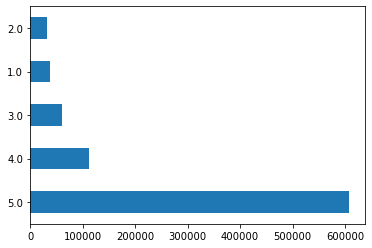

In [29]:
df.overall.value_counts().plot.barh()

Признак overall это 5-ти бальная шкала оценок товаров пользователями. Пропусков нет. Он отсутствует в тестовом датасете. Его можно внести в категориальные признаки.

In [30]:
df['overall']=df['overall'].astype('int32')

In [31]:
cat_cols.append('overall')

In [32]:
df.head(2)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,NaN,117314,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


* verified

In [33]:
print(df.verified.value_counts())
print(df.verified.describe())
print("Пропуски:", df.verified.isnull().sum())

True     736369
False    111224
Name: verified, dtype: int64
count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object
Пропуски: 0


<AxesSubplot:xlabel='verified', ylabel='count'>

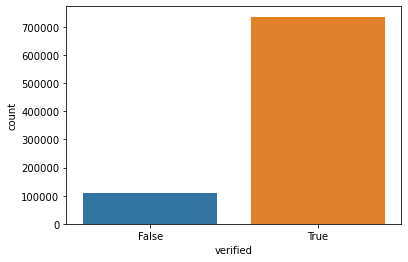

In [34]:
sns.countplot(x = 'verified', data = df)

In [35]:
# Преобразуем значения в колонке verified
df['verified'] = df['verified'].map(lambda x: 1 if x == True else 0).astype('int')

Показатель означает верификацию отзыва пользователя. Имеется в тестовом датасете. Внесем его в список бинарных признаков.

In [36]:
bin_cols.append('verified')

* reviewTime

В описании сказано, что это время написания отзыва, у нас также имеется признак того же самого, но в юниксовом формате unixReviewTime. Очевидно, что признак reviewTime можно и нужно удалить, так как это сто процентная корреляция.

In [37]:
df = df.drop(['reviewTime'], axis=1)

* asin

In [38]:
print(df.asin.value_counts())
print(df.asin.describe())
print("Пропуски:", df.asin.isnull().sum())

B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B001CHJ07Y       1
B000VH6TJS       1
B001QXZ74Y       1
B000X1KBYQ       1
B004VLVQGQ       1
Name: asin, Length: 41302, dtype: int64
count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object
Пропуски: 0


In [39]:
# посмотрим на самую популярную покупкy - это батончик за 13.7 долларов фирмы KIND
pd.set_option('display.max_columns', None)
display(df[df.asin == 'B00BUKL666'][:2])

,overall,verified,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
9103,5,1,B00BUKL666,E.S.,The dark chocolate and sea salt are a deliciou...,Great taste!,1488585600,NaN,NaN,NaN,111921,22208,1.0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nu...",[These bars are where our journey started and ...,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",KIND,18inGroceryGourmetFood(,NaN,Grocery,$13.67,"[B003TNANSO, B003TMZQC8, B00IZF0LCE, B003TN6FS...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
9104,5,1,B00BUKL666,booksrock,Delicious! My second favorite Kind bar!,My second favorite Kind bar,1504137600,NaN,NaN,NaN,123191,22208,1.0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nu...",[These bars are where our journey started and ...,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",KIND,18inGroceryGourmetFood(,NaN,Grocery,$13.67,"[B003TNANSO, B003TMZQC8, B00IZF0LCE, B003TN6FS...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN


Уникальных товаров в нашей базе данных 41302. Не понятно как он может быть полезен. Вероятно, стоит его удалить.

In [40]:
#удаляем
df = df.drop(['asin'], axis=1)

* reviewerName

In [41]:
print(df.reviewerName.value_counts())
print(df.reviewerName.describe())
print("Пропуски:", df.reviewerName.isnull().sum())

Amazon Customer      31346
Kindle Customer       6128
Linda                  729
John                   714
David                  606
                     ...  
Randys                   1
Crisssy                  1
Laurie destuchmsn        1
Lala805                  1
ViperOps                 1
Name: reviewerName, Length: 101207, dtype: int64
count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object
Пропуски: 168


<AxesSubplot:>

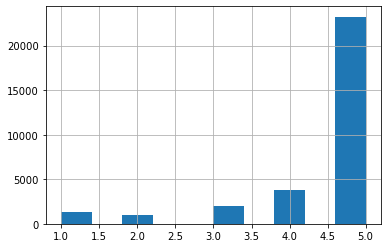

In [42]:
# зависимость оценок от никнейма Амазонский покупатель
df['overall'][df['reviewerName'] == 'Amazon Customer'].hist(bins=10)

Очевидно, что в данном признаке указаны не уникальные имена. Если посмотреть зависимость оценок от наиболее распространенных имен - распределения практически идентичные. Сложно понять как этот признак может быть полезен в модели. Хотя, можно придумать рекомендательную систему 'покупатели с таким же именем как у вас чаще всего покупают...'. Но это не соответствует нашей текущей задаче. Удалим признак.

In [43]:
df = df.drop(['reviewerName'], axis=1)

* reviewText

Этот признак более расширенная версия признака summary его нет в тестовом датасете. Мжно его удалить.

In [44]:
df = df.drop(['reviewText'], axis=1)

* summary

In [45]:
print(df.summary.value_counts())
print(df.summary.describe())
print("Пропуски:", df.summary.isnull().sum())

Five Stars                             171328
Four Stars                              26597
Three Stars                             11913
One Star                                 5300
Two Stars                                4920
                                        ...  
bought this to create my own makeup         1
Great taste and freshness                   1
Cacao nibs are lousy!                       1
Best tasting Stevia Ever!                   1
Husband approves.                           1
Name: summary, Length: 411451, dtype: int64
count         847426
unique        411451
top       Five Stars
freq          171328
Name: summary, dtype: object
Пропуски: 167


Этого признака также нет в тестовой выборке. Но здесь можно поработать в будущем - создать список наиболее популярных слов. Напрмер word_list = ['Five Stars', 'Four Stars'] и т.д. Затем разбить их по критериям и сделать dummy - переменные. Запомним эту мысль на случай, если нам понадобится поработать с доп фичами. А пока удалим.

In [46]:
df = df.drop(['summary'], axis=1)

* unixReviewTime

In [47]:
tsmin = datetime.utcfromtimestamp(df.unixReviewTime.min()).strftime('%Y-%m-%d %H:%M:%S')
tsmax = datetime.utcfromtimestamp(df.unixReviewTime.max()).strftime('%Y-%m-%d %H:%M:%S')

In [48]:
print(tsmin)
print(tsmax)
# все отзывы оставлены в период с 2000 по 2018 год

2000-08-09 00:00:00
2018-10-02 00:00:00


In [49]:
tsmin = df.unixReviewTime.min()
ts25 = int(df.unixReviewTime.quantile(0.25))
ts50 = int(df.unixReviewTime.quantile(0.50))
ts75 = int(df.unixReviewTime.quantile(0.75))
tsmax = df.unixReviewTime.max()

In [50]:
def cat_date(x):
    if x <= ts25: x = 'old'
    elif ts25 < x < ts75: x = 'middle'
    elif ts75 <= x: x = 'new'
    return x      

# Заменим значения в столбце на категории
df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: cat_date(x))

In [51]:
# df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: 'old' if x <= int(df.unixReviewTime.quantile(0.25)) else 'new' if x >= int(df.unixReviewTime.quantile(0.75)) else 'middle')

* vote

In [52]:
print(df.vote.value_counts())
print(df.vote.describe())
print("Пропуски:", df.vote.isnull().sum())

2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
131          1
588          1
97           1
238.0        1
187          1
Name: vote, Length: 477, dtype: int64
count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64
Пропуски: 728732


In [53]:
# Удалим запятые
df['vote'] = df['vote'].astype('str')
df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
# Заменим пропуски на 0
df['vote'] = df['vote'].apply(lambda x: x.replace('nan', '0'))
df.vote = df.vote.fillna(0)
# Приведем к int32
df['vote'] = df['vote'].astype('float')
df['vote'] = df['vote'].astype('int32')

<AxesSubplot:>

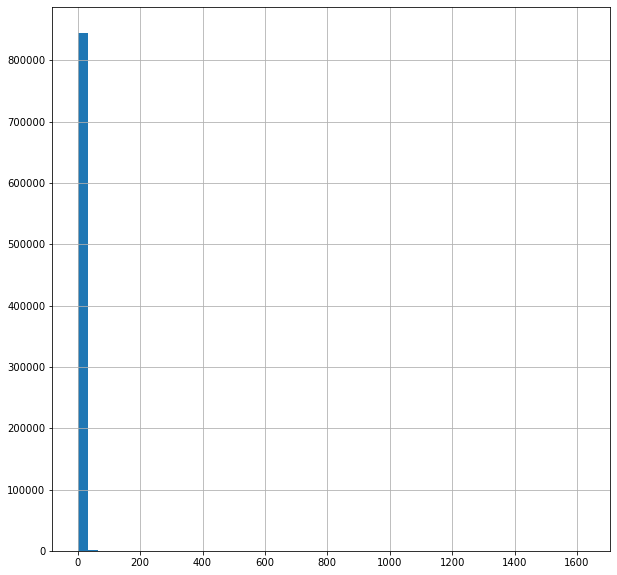

In [54]:
df['vote'].hist(figsize=(10,10), bins=50)
# очевидно, что по большинству отзывов нет оценок

In [55]:
print(df.vote.value_counts())

0      728732
2       44560
3       22305
4       12872
5        8275
        ...  
594         1
218         1
214         1
211         1
507         1
Name: vote, Length: 312, dtype: int64


In [56]:
# сделаем категории по количеству голосов за отзыв
df["vote"] = df["vote"].apply(lambda x: 'low' if x == 0 else
    'high' if x > 50 else 'middle')

In [57]:
df['vote'].value_counts()
# в следующем разделе переведем эти данные в категориальные

low       728732
middle    117360
high        1501
Name: vote, dtype: int64

* style

Несмотря на то,что данный признак имеется в тестовом датасете, также там очень много пропусков. Сами признаки тяжелы для обработки. Удалим.

In [58]:
df = df.drop(['style'], axis=1)

* image_x

In [59]:
# данный признак почти весь состоит из пропусков. Удалим
df = df.drop(['image_x'], axis=1)

* userid

In [60]:
print(df.userid.value_counts())
print(df.userid.describe())
print("Пропуски:", df.userid.isnull().sum())

842      427
17987    317
355      302
2024     296
2809     279
        ... 
66068      1
71046      1
90602      1
37414      1
77032      1
Name: userid, Length: 127448, dtype: int64
count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64
Пропуски: 0


id пользователя, признак без пропусков. Числовой.

In [61]:
num_cols.append('userid')

* itemid

In [62]:
print(df.itemid.value_counts())
print(df.itemid.describe())
print("Пропуски:", df.itemid.isnull().sum())

22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
38965       1
23635       1
34272       1
39917       1
38902       1
Name: itemid, Length: 41302, dtype: int64
count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64
Пропуски: 0


Не забыть проверить в тестовом и тренировочном датасетах пропущенные id. Это может понадобится в будущем c item_features.

In [63]:
num_cols.append('itemid')

* rating

In [64]:
print(df.rating.value_counts())
print(df.rating.describe())
print("Пропуски:", df.rating.isnull().sum())

1.0    719392
0.0    128201
Name: rating, dtype: int64
count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64
Пропуски: 0


In [65]:
# бинарный признак, который вероятно определяет хороший товар или нет
df['rating']=df['rating'].astype('int32')

In [66]:
bin_cols.append('rating')

* category

In [67]:
print(df.category.value_counts())
print(df.category.describe())
print("Пропуски:", df.category.isnull().sum())

[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Coffee, Single-Serve Capsules & Pods]     54966
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Green]                               20301
[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]                                              15472
[Grocery & Gourmet Food, Candy & Chocolate, Candy & Chocolate Bars]                                15198
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Coffee, Roasted Coffee Beans]             14367
                                                                                                   ...  
[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Havarti]                                        3
[Grocery & Gourmet Food, Sauces, Gravies & Marinades, Sauces, Spanish & Mexican, Sofrito Sauce]        3
[Grocery & Gourmet Food, Fresh Flowers & Live Indoor Plants, Fresh Cut Flowers, Tulips]                2
[Grocery & Gourmet Food, Produce, Fresh Vegetables, Tom

In [68]:
# удалим признак
df = df.drop(['category'], axis=1)

* description

In [69]:
# описание продукта, удалим
df = df.drop(['description'], axis=1)

* title

In [70]:
print(df.title.value_counts())
print(df.title.describe())
print("Пропуски:", df.title.isnull().sum())

KIND Bars, Dark Chocolate Nuts & Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count    7435
KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count       4733
Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz                 4611
Twinings of London Pure Camomile Herbal Tea Bags, 20 Count                          4252
KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count       3079
                                                                                    ... 
Eclipse Winterfrost Mints - 8 Tins                                                     1
Popchips, Parmesan Garlic, 3-Ounce Bags (Pack of 12)                                   1
2 Packs of Trader Joe's Organic Liquid Stevia                                          1
Nespresso OriginalLine: Volluto, 50 Count - ''NOT compatible with Vertuoline''         1
Old Fashioned Cheese Jalapeno Squeeze Cheese, 11.5 Ounce                               1
Name: title, Length: 

In [71]:
# можно сделать категориальный признак по наиболее частым продуктам. 
# Но удалим из-за нехватки времени и ненадежности результата.
# df = df.drop(['title'], axis = 1)

* brand

In [72]:
print(df.brand.value_counts())
print(df.brand.describe())
print("Пропуски:", df.brand.isnull().sum())

KIND              22506
Bob's Red Mill    13061
Twinings          11182
Planters          10384
Frontier           6926
                  ...  
Builders Tea          1
Boboli                1
Novus Tea             1
bioAllers             1
Brooks                1
Name: brand, Length: 8866, dtype: int64
count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object
Пропуски: 6104


In [73]:
# Заметим,что у нас большое количество бренда именно "KIND", попробуем сделать из него новый признак
df['brand_kind'] = df.brand.apply(lambda x: 1 if x=='KIND' else 0)

In [74]:
df['brand_kind'].value_counts()
bin_cols.append('brand_kind')

Уникальных брендов 8866, есть некоторое количество пропусков, которые легко заполнить. Не думаю, что из этого признака будет правильно делать категориальные. Удалим.

In [75]:
df = df.drop(['brand'], axis = 1)

* rank

In [76]:
df['rank'][1470]

'2,330inGroceryGourmetFood('

In [77]:
# удалим
df = df.drop(['rank'], axis = 1)

* main_cat	

In [78]:
print(df.main_cat.value_counts())
print("Пропуски:", df.main_cat.isnull().sum())

Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Musical Instruments               3
Software                          3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64
Пропуски: 955


Указана категория, в которой определен товар. В нашей базе безусловным лидером является категория Бакалея. Есть пропуски, для которых можно создать категорию others. Далее сделаем из этого признака dummy-переменные или просто label encoding, также на будущее можно часть мало распространенных категорий переименовать в others.

In [79]:
df.main_cat = df.main_cat.fillna('others')

* price

In [80]:
print(df.price.value_counts())
print(df.price.describe())
print("Пропуски:", df.price.isnull().sum())

$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$30.64                  2
$6.93                   1
$19.99 - $295.00        1
$35.16                  1
$44.14                  1
Name: price, Length: 4601, dtype: int64
count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object
Пропуски: 258621


In [81]:
df['price'].sample(10)

450747       NaN
638060     $7.90
506903    $21.26
703027    $65.99
810002       NaN
65714     $22.95
455853       NaN
305026       NaN
590468       NaN
133292    $52.99
Name: price, dtype: object

C этим признком можно поработать. Удалить пропуски, подготовить к категорированию.

In [82]:
df['price'] = df['price'].astype('str')

In [83]:
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))

In [84]:
df['price'] = df['price'].apply(lambda x: 0 if x == '' else x)

In [85]:
df['price'] = df['price'].astype('float')

In [86]:
df['price'] = df['price'].apply(lambda x: x/100)

In [87]:
# стоит определить выбросы, иначе есть риск неверного определения и замены пропусков на среднее
# использую функцию из ранних проектов
def IQR(column):
    perc_25 = df[column].quantile(0.25, interpolation="midpoint")
    perc_75 = df[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    min_out = perc_25 - 1.5 * IQR
    max_out = perc_75 + 1.5 * IQR
    print('Всего выбросов: {} '.format(
        df[df[column] > max_out][column].count()+df[df[column] < min_out][column].count()))
    print('Верхняя граница выбросов:',max_out)

In [88]:
IQR('price')
# выбросов достаточно много. Экспертным путем отсечем все дороже 100 долларов

Всего выбросов: 18599 
Верхняя граница выбросов: 53.75


In [89]:
df['price'] = df['price'].apply(lambda x: 0 if x > 100 else x)

In [90]:
# Заменим нули на среднее значение
df['price'] = df['price'].astype('int')
a = df['price'].mean()
df['price'] = df['price'].apply(lambda x: a if x == 0 else x)

In [91]:
print(df.price.value_counts())
print(df.price.describe())
print("Пропуски:", df.price.isnull().sum())

13.455983    264415
14.000000     41302
13.000000     33267
9.000000      26349
11.000000     23830
              ...  
88.000000        20
90.000000        19
81.000000        16
97.000000        12
91.000000         7
Name: price, Length: 100, dtype: int64
count    847593.000000
mean         17.653710
std          10.842770
min           1.000000
25%          13.000000
50%          13.455983
75%          20.000000
max          99.000000
Name: price, dtype: float64
Пропуски: 0


In [92]:
# сделаем категории по цене
df["price"] = df["price"].apply(lambda x: 'low' if x < 10 else
    'high' if x > 20 else 'middle')

* also_buy и also_view

In [93]:
df.also_buy[78]
# очевидно, что это также купленные товары по asin, удалим на данном этапе

['B000T9WLUY',
 'B01K23RF7U',
 'B0015GSBUY',
 'B00112KVNW',
 'B004QE5BBE',
 'B01BHJVTJS',
 'B0744J1PTV',
 'B004BQ4V4A',
 'B004QE181G',
 'B01AZ15AMQ',
 'B07CX3FHMB',
 'B0014D0SDG',
 'B00FZGZKHW']

In [94]:
df.also_view[78]

['B006K3UC86', 'B000WGB3OY']

In [95]:
print("Пропуски:", df.also_buy.isnull().sum())
print("Пропуски:", df.also_view.isnull().sum())

Пропуски: 120735
Пропуски: 384222


Данный признак, вероятно говорит о том, что покупатели конкретного товара еще просматривали. Пропуски могут говорить о том, что покупатель не смотрел больше ничего. 

In [96]:
# coздадим пару features - количество продуктов и количество просмотров
df['also_buy_numb'] = df['also_buy'].str.len()
df['also_view_numb'] = df['also_view'].str.len()
df['also_buy_numb'] = df['also_buy_numb'].fillna(0)
df['also_view_numb'] = df['also_view_numb'].fillna(0)
df['also_buy_numb'] = df['also_buy_numb'].astype(int)
df['also_view_numb'] = df['also_view_numb'].astype(int)

In [97]:
num_cols.append('also_buy_numb')
num_cols.append('also_view_numb')

In [98]:
df = df.drop(['also_buy'], axis = 1)
df = df.drop(['also_view'], axis = 1)

Анализ данных, проведенный выше, позволяет нам принять решение удалить оставшиеся признаки. Основная причина - огромое количество пропусков.

In [99]:
df.head(2)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,image_y,date,feature,details,similar_item,tech1,fit,brand_kind,also_buy_numb,also_view_numb
0,5,1,middle,low,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,0,85,54
1,5,0,new,low,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,0,85,54


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         847593 non-null  int32 
 1   verified        847593 non-null  int32 
 2   unixReviewTime  847593 non-null  object
 3   vote            847593 non-null  object
 4   userid          847593 non-null  int64 
 5   itemid          847593 non-null  int64 
 6   rating          847593 non-null  int32 
 7   title           847593 non-null  object
 8   main_cat        847593 non-null  object
 9   price           847593 non-null  object
 10  image_y         755354 non-null  object
 11  date            12087 non-null   object
 12  feature         142734 non-null  object
 13  details         832985 non-null  object
 14  similar_item    1138 non-null    object
 15  tech1           4372 non-null    object
 16  fit             0 non-null       object
 17  brand_kind      847593 non-nu

* image_y

In [101]:
df.image_y.isna().sum()

92239

Обычно наличие фотографии продукта вызывает больше доверия у потребителя,покупая через интернет. Поэтому создадим бинарный признак на наличие фотографии у продавца, а сам признак image_y далее удалим

In [102]:
df['image_y'] = df['image_y'].fillna(0)

In [103]:
df['image']= df['image_y'].apply(lambda x: 0 if x==0 else 1)
df['image']

0         1
1         1
2         1
3         1
4         1
         ..
847588    1
847589    1
847590    1
847591    0
847592    0
Name: image, Length: 847593, dtype: int64

In [104]:
bin_cols.append('image')

In [105]:
df = df.drop(['image_y', 'date', 'feature', 'details', 'similar_item', 'tech1', 'fit'], axis=1)

In [106]:
df.head(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
0,5,1,middle,low,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,0,85,54,1
1,5,0,new,low,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,0,85,54,1
2,3,1,new,middle,119505,37138,0,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,0,85,54,1


Краткий итог EDA. Получилось достаточно большая база, с которой можно творчески работать практически до бсконечности. От большинства признаков по разным причинам пришлось избавиться. Осталось 9 признаков. 4 из которых бинарные, 2 числовых и остальные категориальные. С частью из них поработаем с помощью label encoding.

# Future Engeneering

In [107]:
# преобразование с помощью LabelEncoder()
label_encoder = LabelEncoder()
# преобразуем категории времени в числовые
mapped = pd.Series(label_encoder.fit_transform(df['unixReviewTime']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'middle', 1: 'new', 2: 'old'}


In [108]:
df['unixReviewTime'] = label_encoder.fit_transform(df['unixReviewTime'])
df.sample(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
753348,4,0,2,low,288,7324,1,Gatorade Performance Series Protein Recovery S...,Grocery,middle,0,0,2,1
248703,5,1,0,middle,59343,37132,1,"NUTS U.S. - Dried Apricots, Gourmet Turkish Ap...",Grocery,high,0,80,0,1
730032,5,1,1,low,126269,41197,1,"Jimmy Dean, Turkey Bacon Delight Frittata, 6 c...",Grocery,middle,0,1,1,1


In [109]:
cat_cols.append('unixReviewTime')

In [110]:
# преобразуем признак vote
mapped = pd.Series(label_encoder.fit_transform(df['vote']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'high', 1: 'low', 2: 'middle'}


In [111]:
df['vote'] = label_encoder.fit_transform(df['vote'])
df.sample(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
613247,4,1,0,1,67744,14047,1,Sqwincher 20 oz Zero Sugar Free Wide Mouth Rea...,Industrial & Scientific,high,0,0,0,1
45527,5,1,2,1,20292,9256,1,The Spice Lab Pink Himalayan Salt - 1 Pound X-...,Grocery,low,0,67,0,1
623861,3,1,0,2,24260,18228,0,"Dak, Premium Ham, 16oz Can (Pack of 3)",Grocery,high,0,69,0,1


In [112]:
cat_cols.append('vote')

In [113]:
# следующее main_cat
mapped = pd.Series(label_encoder.fit_transform(df['main_cat']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'All Beauty', 1: 'Amazon Home', 2: 'Arts, Crafts & Sewing', 3: 'Baby', 4: 'Camera & Photo', 5: 'Cell Phones & Accessories', 6: 'Grocery', 7: 'Health & Personal Care', 8: 'Home Audio & Theater', 9: 'Industrial & Scientific', 10: 'Musical Instruments', 11: 'Office Products', 12: 'Pet Supplies', 13: 'Software', 14: 'Sports & Outdoors', 15: 'Tools & Home Improvement', 16: 'Toys & Games', 17: 'others'}


In [114]:
df['main_cat'] = label_encoder.fit_transform(df['main_cat'])
df.sample(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
480994,5,1,0,1,100241,22536,1,"Bai Coconut Flavored Water, Molokai Coconut, A...",6,high,0,95,0,1
395685,5,1,0,1,37129,2466,1,"Heinz Organic Tomato Ketchup, 15 Ounce (Pack o...",6,middle,0,95,48,1
592884,5,1,0,1,64921,40125,1,"Jansal Valley Ground White Pepper, 16 Ounce",6,middle,0,0,0,1


In [115]:
cat_cols.append('main_cat')

In [116]:
# для разнообразия сделаем dummy-переменные по признаку price
dummies = pd.get_dummies(df['price'], prefix = df['price'].name)

In [117]:
df.head(2)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
0,5,1,0,1,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,low,0,85,54,1
1,5,0,1,1,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,low,0,85,54,1


In [118]:
df = df.drop(df['price'].name, axis=1).join(dummies)

In [119]:
bin_cols.append('price_high')
bin_cols.append('price_middle')
bin_cols.append('price_low')

In [120]:
bin_cols

['verified',
 'rating',
 'brand_kind',
 'image',
 'price_high',
 'price_middle',
 'price_low']

In [121]:
df.head(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,brand_kind,also_buy_numb,also_view_numb,image,price_high,price_low,price_middle
0,5,1,0,1,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,0,85,54,1,0,1,0
1,5,0,1,1,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,0,85,54,1,0,1,0
2,3,1,1,2,119505,37138,0,"Primal Palate Organic Spices Adobo Seasoning, ...",6,0,85,54,1,0,1,0


<AxesSubplot:>

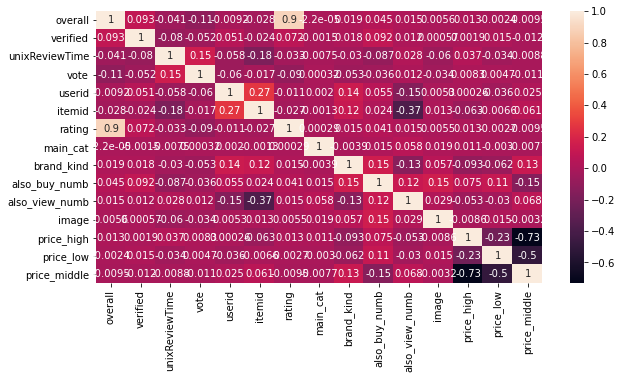

In [122]:
# продолжим анализ признаков, начнем с простого - матрица корреляций 
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True)
# логично данную матрицу применять для числовых признаков, но также очевидна
# корреляция между overall и rating, что соответствует заданию
# стоит подумать над удалением одного из признаков

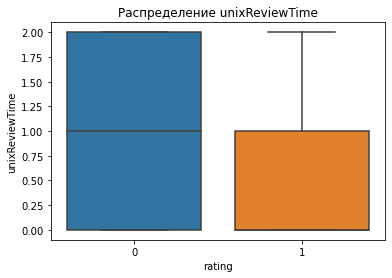

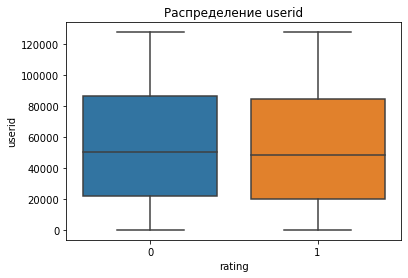

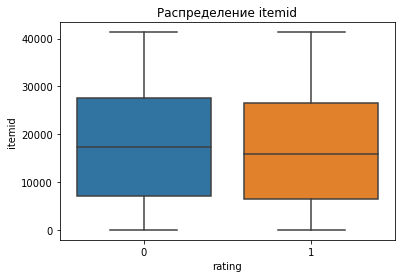

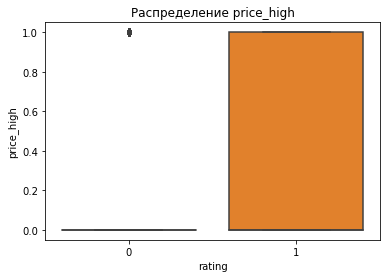

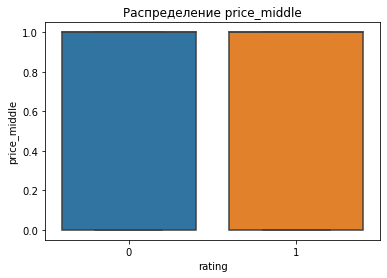

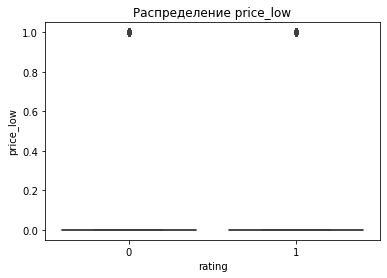

In [123]:
# для получения большей информации стоит построить боксплоты зависимостей от overall или рейтинга
for col in ['unixReviewTime', 'userid', 'itemid', 'price_high', 'price_middle', 'price_low']:
    plt.title(f"Распределение {col}")
    sns.boxplot(x='rating', y=col, data=df)
    plt.show()

Распределения достаточно ожидаемые. Интересный факт, что у товаров с высокой ценой положительный рейтинг.

<AxesSubplot:>

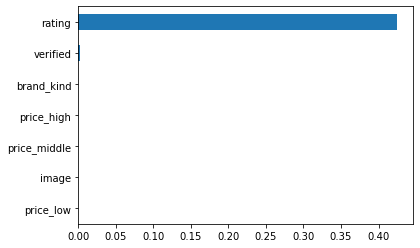

In [124]:
# Проверим значимость бинарных переменных:
imp_bin = Series(mutual_info_classif(df[bin_cols], df['rating'],
                                     discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

Очевидно, что признак price_low имеет очень малую значимость. Стоит рассмотреть удаление

<AxesSubplot:>

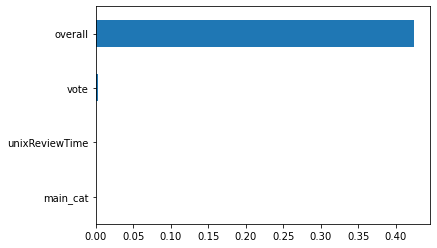

In [125]:
# Проверим значимость категориальных переменных:
imp_cat = Series(mutual_info_classif(df[cat_cols], df['rating'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

На данном графике признак main_cat не является значимым. Стоит признать, что графическое представление наших данных не очень информативно. Рассмотрим другие методы.

In [126]:
# Применим метод Стьюдента
# используем функцию из предыдущего проекта
from itertools import combinations
from scipy.stats import ttest_ind

In [127]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break

In [128]:
for col in bin_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки rating
Найдены статистически значимые различия для колонки brand_kind
Найдены статистически значимые различия для колонки image
Найдены статистически значимые различия для колонки price_high
Найдены статистически значимые различия для колонки price_middle
Найдены статистически значимые различия для колонки price_low


Похоже, что все признаки могут быть полезны.

In [129]:
# удалим overall из-за его высокой корелляции 
df = df.drop(['overall'], axis = 1)

# Построение модели

* Простая модель

In [130]:
import scipy.sparse as sparse
from sklearn import preprocessing
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

In [131]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [132]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [133]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения
RANDOM_STATE = 32


model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [134]:
#Получаем предсказание:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [135]:
# Подсчитываем метрику roc_auc_score
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7315118251480361

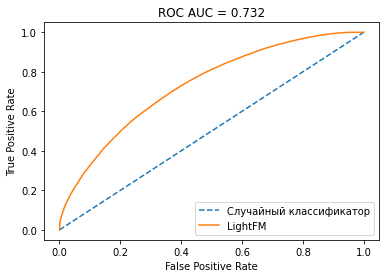

In [136]:
#Cтроим ROC AUС
roc_auc_curve(test_data.rating,preds)

In [137]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [138]:
preds.min(), preds.max()

(-34.03071, 33.507935)

In [139]:
normalized_preds.min(), normalized_preds.max()


(0.0, 1.0)

Проведем эксперимент,обучив на train, не разделяя его и предскажем rating на test

In [140]:
ratings_coo1 = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'])))
model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)

model1 = model.fit(ratings_coo1, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

#Получаем предсказание:
preds1 = model1.predict(test.userid.values,
                      test.itemid.values)

In [141]:
normalized_preds1 = (preds1 - preds1.min())/(preds1 - preds1.min()).max()

In [142]:
preds1.min(), preds1.max()

(-36.284546, 29.661137)

In [143]:
normalized_preds1.min(), normalized_preds1.max()

(0.0, 1.0)

In [144]:
test['pred_rating'] = normalized_preds1
test

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id,pred_rating
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0,0.580977
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1,0.570832
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2,0.556842
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3,0.557325
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4,0.575468
...,...,...,...,...,...,...,...,...,...,...,...,...
285960,True,"01 17, 2016",B00FLD3X28,A. Banks,1452988800,NaN,{'Size:': ' 1 Pound'},NaN,294,25601,285960,0.586214
285961,True,"08 22, 2015",B0078DQ85S,HighEnergy,1440201600,NaN,{'Flavor:': ' Cinnamon & Currant'},NaN,119653,18204,285961,0.485363
285962,True,"09 21, 2017",B000FZVLFS,Sam Jackson,1505952000,NaN,{'Flavor:': ' Espresso Forte'},NaN,54673,2287,285962,0.569793
285963,True,"03 27, 2018",B001PB801Y,Louis J. Dezseran Sr.,1522108800,NaN,{'Size:': ' 5lb'},NaN,16569,9343,285963,0.573163


Теперь проведем обучение и предскажем на очищенных данных

In [145]:
train_data, test_data = train_test_split(df,random_state=32, shuffle=True)
ratings_coo2 = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)
model2 = model.fit(ratings_coo2, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [146]:
#Получаем предсказание:
preds2 = model2.predict(test_data.userid.values,
                      test_data.itemid.values)

In [147]:
# Подсчитываем метрику roc_auc_score
sklearn.metrics.roc_auc_score(test_data.rating,preds2)

0.7419578807987918

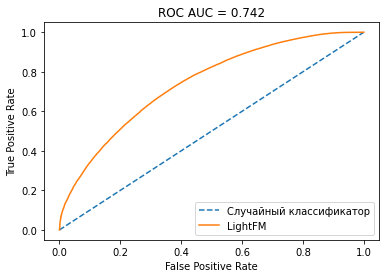

In [148]:
#Cтроим ROC AUС
roc_auc_curve(test_data.rating,preds2)

видим,что метрика немного улучшилась

In [149]:
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()
preds2.min(), preds2.max()

(-35.75574, 27.413054)

In [150]:
normalized_preds2.min(), normalized_preds2.max()

(0.0, 1.0)

In [151]:
preds_sub = model2.predict(test.userid.values,
                      test.itemid.values)

In [152]:
normalized_preds_sub = (preds_sub - preds_sub.min())/(preds_sub - preds_sub.min()).max()
preds_sub.min(), preds_sub.max()

(-33.06127, 28.156012)

In [153]:
normalized_preds_sub.min(), normalized_preds_sub.max()

(0.0, 1.0)

из-за ошибки с памятью на kaggle,закомментируем работу с item и user features

In [154]:
#укажем в item_features признаки,описывающие товар и затем сделаем разреженную матрицу item_features для дальнейшего использования в моделе
item_features = train_data[['image','main_cat','brand_kind','price_high','price_low','price_middle','image']]
norm_ifeatures = (item_features - item_features.mean()) / item_features.std()
item_features=(sparse.csr_matrix(norm_ifeatures)).astype(np.float32)

In [155]:
# сделаем разреженную матрицу user_features,содержащий признаки,описывающие потребителя
user_features = train_data[['verified','unixReviewTime','vote','also_buy_numb','also_view_numb']]
norm_ufeatures = (user_features - user_features.mean()) / user_features.std()
user_features = (sparse.csr_matrix(norm_ufeatures)).astype(np.float32)

In [156]:
NUM_THREADS = 4  # число потоков
NUM_COMPONENTS = 160  # число параметров вектора
NUM_EPOCHS = 20  # число эпох обучения
RANDOM_STATE = 32
model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model_feat = model.fit(ratings_coo, user_features=user_features, item_features=item_features, epochs=NUM_EPOCHS,
                       num_threads=NUM_THREADS)

In [157]:
#для предсказаний используем матрицы 
userid = np.array(test_data.userid).astype(np.int32)
itemid =np.array(test_data.itemid).astype(np.int32) 

In [183]:
# Получаем предсказание:
preds0 = model_feat.predict(userid, itemid, item_features=item_features,
                            user_features=user_features,num_threads=NUM_THREADS)

In [159]:
# Подсчитываем метрику roc_auc_score
sklearn.metrics.roc_auc_score(test_data.rating,preds0)

0.4990821753364155

In [178]:
# ui = np.hstack((item_features, user_features))

In [187]:
ads=sparse.coo_matrix((test_data['rating'].astype(int),
                                 (test_data['userid'],
                                  test_data['itemid'])))

In [188]:
#Тестируем нашу модель
prec_score = precision_at_k(
                     model_feat,
                     ads,
                     num_threads=NUM_THREADS,
                     k=10,
                     item_features=item_features).mean()
 
recall_at_k = recall_at_k(model_feat,
                     ads,
                     num_threads=NUM_THREADS,
                     k=10,
                     item_features=item_features).mean()

print(recall_at_k,prec_score)

ValueError: The user feature matrix specifies more features than there are estimated feature embeddings: 5 vs 127496.

результат метрики roc_auc: 0.5005192169802185

In [ ]:
# Достаём эбмеддинги

item_biases, item_embeddings = model2.get_item_representations()

In [ ]:
item_biases.shape, item_embeddings.shape

Мы получили эмбеддинги. Эмбеддинги нам нужны, чтобы давать предсказание к каждому товару, а точнее искать наиболее похожие. Для быстрого поиска среди большого количества товаров будем использовать метод ближайших соседей, approximate k-nn, который реализован в библиотеке nmslib.  

Вместо того, чтобы перебирать все вершины, мы можем очень быстро обходить граф.

In [ ]:
!pip install nmslib

In [ ]:
import nmslib
 
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [ ]:
#Вспомогательная функция для поиска по графу
def nearest_item_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

In [ ]:
mapper = dict(zip(meta['asin'],meta['title']))

In [ ]:
# Создадим dataframe prod_id
train['title'] = train.asin.apply(lambda x: mapper[x])
test['title'] = test.asin.apply(lambda x: mapper[x])
prod_id = train.drop(['verified','reviewTime','reviewerName','reviewText','summary','unixReviewTime','vote','style','image'],axis=1)

Попробуем написать рекомендации к какому-нибудь товару. Например, к 'chocolate'.

In [ ]:
prod_id[prod_id.title.str.find('chocolate')>=0].head(5)

возьмем item_id == 31074

In [ ]:
# Ищем похожие товары
nbm = nearest_item_nms(31074,nms_idx)[0]

In [ ]:
#Выведим их
prod_id[prod_id.itemid.isin(nbm)]

In [ ]:
submission['rating']= normalized_preds_sub

In [ ]:
submission

In [ ]:
submission.to_csv('submission_log.csv', index=False)

Вывод:

Мы удачно завершили проект по созданию рекомендательной системы. Мы подготовили ряд последовательных моделей для оценки проекта с помощью метрики ROC AUC. Которая характеризует точность предсказаний и должна быть устойчива к несбалансированным классам.

Мы провели большую работу по EDA и FEБ, но начать решили с простой модели, это, ожидаемо , не дало нам нужного эффекта, но задало точку отсчета. Следующим шагом было увеличение данных, на котором модель обучалась – результат улучшился до показателя 0.7495 при сабмите, что уже заметно лучше базового решения. Следующим шагом стала работа с item_features и эмбедингами. Эмбеддинги – это векторы меньшей размерности в машинном обучении. Они используются для описания текстов, изображений, видео и много другого в поисковых и рекомендательных системах. Эмбеддинги нам нужны, чтобы давать предсказание к каждому товару, а точнее искать наиболее похожие. С помощью user/item_features мы добавили наши фичи. Если мы используем user/item_features при обучении, то LifhtFM считает,  что каждый пользователь и элемент характеризуются одной характеристикой, уникальной для этого пользователя (или элемента). Для быстрого поиска среди большого количества товаров использовали метод ближайших соседей, approximate k-nn, который реализован в библиотеке nmslib. К сожалению, данную модель мы не стали использовать для сабмита, поскольку выбранная нами метрика близка к 0.5.

Обоснование выбранной метрики.


В рамках целей и задач создания рекомендательной системы мы определили, что рекомендательная система должна быть нацелена на увеличения прибыли он-лайн магазина. Таким образом из пяти наиболее устоявшихся бизнес-метрик для оценки РС мы остановились на Sales and Revenue, а также можно считать, что наша РС может влиять на такие показатели как User Engagement and Behavior и Effects on Sales Distribution причем необязательно в положительную сторону. Это может зависеть как от самой рекомендательной системы, так и от ее интерфейса, удобства и степени доверия клиентов к ней.

Метрика ROC-AUC наиболее подходит для оценки точности прогнозирования рекомендуемых товаров для увеличения продаж. 
Можно добавить, что если пользователей интересуют только товары с самым высоким (или самым низким рейтингом), а не отдельные рейтинговые оценки, это предполагает задачу классификации или ранжирования. Хотя алгоритм может использовать прогнозируемые рейтинги внутри, он должен успешно оценивать товары с наивысшим рейтингом (или с низким рейтингом), и более высокая ошибка в прогнозах рейтинга для товаров приемлема, если товары с наивысшим рейтингом (или с самым низким рейтингом) идентифицированы правильно. Поэтому оценка должна быть сосредоточена на показателях классификации или ранжирования.

Графическое изображение ROC AUC обеспечивает графическое представление производительности рекомендательной системы или любого другого типа двоичного классификатора. Она отображает True Positive rate против False Positive rate для увеличения размера набора рекомендаций.  Oчевидной целью является максимизация площади под кривой. Таким образом, площадь под кривой AUC может использоваться в виде единственного показателя общего качества рекомендательной системы. Тем не менее бывает, что пользователи часто больше интересуются товарами в верхней части списков рекомендаций, но показатель AUC в равной степени зависит от свопов в верхней или нижней части списка рекомендаций. Это может быть недостатком, если мы, в основном, заинтересованы в поиске элементов с наивысшим рейтингом и, следовательно, заботимся о первой части графика. Решить эту проблему в будущем можно с помощью LAUC (Limited Area Under the Curve). Мера LAUC может быть очень полезна для оценки рекомендательных систем, которые применяются для создания списков товаров высшего качества.
